In [1]:
#importing the required libraries\n",
import pandas as pd
import numpy as np
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import string
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score

In [2]:
# reading the data
df=pd.read_csv("train_news.csv")
df_copy=df.copy()

In [3]:
# exploring the dataset
df.head()

,Unnamed: 0,id,headline,written_by,news,label
0,0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1


In [4]:
df.shape

(20800, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  20800 non-null  int64 
 1   id          20800 non-null  int64 
 2   headline    20242 non-null  object
 3   written_by  18843 non-null  object
 4   news        20761 non-null  object
 5   label       20800 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 975.1+ KB


In [6]:
# checking the data balance
(len(df[df['label']==1])/len(df))*100

50.0625

 As we can see there are null values in the dataset. Lets check the % of null-values in each column"

In [7]:
(df.isnull().sum()/len(df.index))*100

Unnamed: 0    0.000000
id            0.000000
headline      2.682692
written_by    9.408654
news          0.187500
label         0.000000
dtype: float64

As we can see there is almost 10% null values in the "written_by" column . For this column we can impute the most frequent occuring 
writer name.Lets find the most frequent occuring writer name.

In [8]:
df['written_by'].value_counts()

Pam Key                               243
admin                                 193
Jerome Hudson                         166
Charlie Spiering                      141
John Hayward                          140
                                     ... 
mleblanc138                             1
samar pahwa                             1
WhiteRefugee                            1
Graham Bowley and Sydney Ember          1
Andrea Kannapell and Zach Montague      1
Name: written_by, Length: 4201, dtype: int64

In [9]:
# Lets impute "Pam Key" in place of null values in "written_by" column
df['written_by']=df['written_by'].fillna("Pam Key")

The other two columns "headlines" and "news" has less than 2.5 %  of null values. so we can drop those rows
without losing much data.

In [10]:
df=df[~(df['headline'].isnull()|df['news'].isnull())]


In [11]:
# checking now the null values
df.isnull().sum()/len(df.index)

Unnamed: 0    0.0
id            0.0
headline      0.0
written_by    0.0
news          0.0
label         0.0
dtype: float64

Lets now do some feature engineering

In [12]:
df["length_headline"]=[len(i) for i in df["headline"]]
df["length_news"]=[len(i) for i in df["news"]]

Lets do some visualization to check if the length features can be useful for analysis

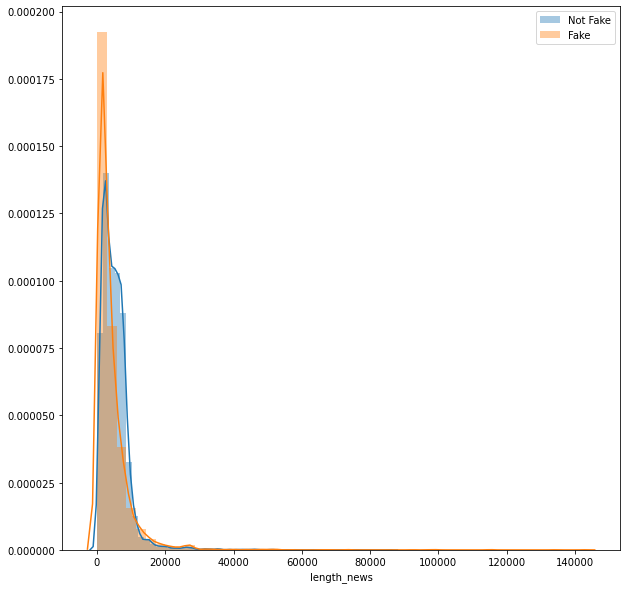

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
sns.distplot(df[df['label']==0]["length_news"],label="Not Fake")
sns.distplot(df[df['label']==1]["length_news"],label="Fake")
plt.legend()

We can observe from the above plot. Although the difference in the news_length distribution is not much but
Fake news are a bit shorter in length than Non-Fake news.

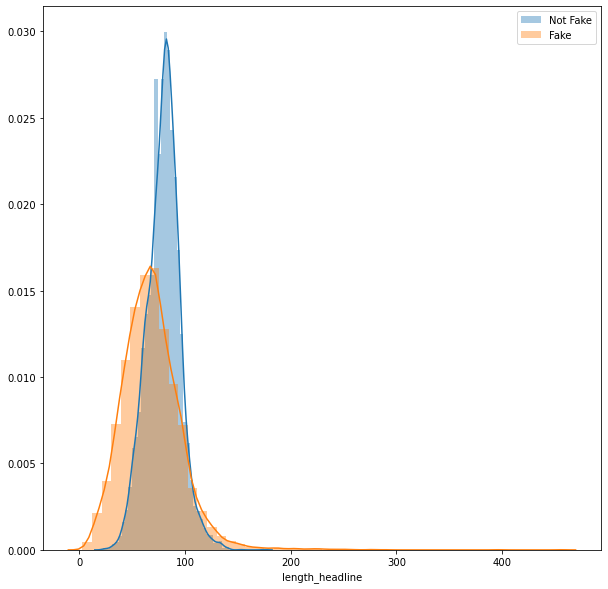

In [14]:
plt.figure(figsize=(10,10))
sns.distplot(df[df['label']==0]["length_headline"],label="Not Fake")
sns.distplot(df[df['label']==1]["length_headline"],label="Fake")
plt.legend()

We can observe from the above plot. Although the difference in the headlines_length distribution is not much but Fake news are a bit shorter in length than Non-Fake news.

"Dropping the unecessary columns 'id','unnamed'. These columns are just the ids of the news articles so they won't be useful
    for our analysis"

In [15]:
df.drop(['Unnamed: 0','id'],axis=1,inplace=True)

In [16]:
# creating text- preprocessing function
def preprocess_text(text):
        text = text.lower() #converting to lower case

        text = re.sub(r'\\d+', '', text) # removing the numbers if any 
        #removing the punctuation marks
        x=""
        for i in text:
            if i not in set(string.punctuation) :
                x=x+i  
        text=x
        
    
        text= text.strip() #removing whitespaces
        
        #tokenizing and removing stopwords
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(text)
        tokens = [i for i in tokens if  i not in stop_words]
    
        #lemmatizing to the base words
        lemmatizer=WordNetLemmatizer()
        lemma_tokens=[lemmatizer.lemmatize(word) for word in tokens]
    
        return " ".join(lemma_tokens)
   

In [19]:
# cleaning the text data in the data
df['headline']=[preprocess_text(token) for token in df["headline"]]
                                                       
df['news']=[preprocess_text(token) for token in df["news"]]

In [20]:
# Creating X and y Subsets
X=df.drop(['label'],axis=1)
y=df['label']

In [21]:
# creating the train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [22]:
# creating bow for the two columns "headlines","news"
Tf_vectorizer_headline=TfidfVectorizer(max_df=0.7)
headline_tf_train=Tf_vectorizer_headline.fit_transform(X_train["headline"])
headline_tf_test=Tf_vectorizer_headline.transform(X_test["headline"])

Tf_vectorizer_news=TfidfVectorizer(max_df=0.7)
news_tf_train=Tf_vectorizer_news.fit_transform(X_train["news"])
news_tf_test=Tf_vectorizer_news.transform(X_test["news"])


In [23]:
# AS the "written_by" is categorical variable lets convert it in to the numerical form
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
written_by_train=encoder.fit_transform(X_train["written_by"])
written_by_test=encoder.fit_transform(X_test["written_by"])

In [24]:
# creating the dataset for training
from scipy import sparse
arr_train=np.c_[np.array(X_train['length_news']),np.array(X_train['length_headline']),np.array(written_by_train)]
X_train_full=sparse.hstack([headline_tf_train,news_tf_train,arr_train])

arr_test=np.c_[np.array(X_test['length_news']),np.array(X_test['length_headline']),np.array(written_by_test)]
X_test_full=sparse.hstack([headline_tf_test,news_tf_test,arr_test])

Model Building Starts From here

In [25]:
from sklearn.naive_bayes import MultinomialNB
#import math
naive=MultinomialNB()
naive.fit(X_train_full,y_train)

MultinomialNB()

In [26]:
# checking the models accuracy on train set

pred =naive.predict(X_train_full)
score = metrics.accuracy_score(y_train, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.625


In [27]:
# checking the models accuracy on test set

pred =naive.predict(X_test_full)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.633


As We can see the Naive Baiyes is not performing well on both the training and test dataset.

Lets now try Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
lgr=LogisticRegression()
lgr.fit(X_train_full, y_train)


LogisticRegression()

In [29]:
# Lets see the performance of the logistic model on train dataset
pred =lgr.predict(X_train_full)
score = metrics.accuracy_score(y_train, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.942


In [30]:
# Lets see the performance of the logistic model on test dataset
pred =lgr.predict(X_test_full)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.938


So, the performance of the logistic model is excellent on both the training (94.2%) and test data (93.8%)

In [31]:
# Lets Now try the Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
rfc.fit(X_train_full, y_train)


RandomForestClassifier()

In [32]:
# Lets see the performance of the random forest model on train dataset
pred =rfc.predict(X_train_full)
score = metrics.accuracy_score(y_train, pred)
print("accuracy:   %0.3f" % score)

accuracy:   1.000


In [33]:
# Lets see the performance of the random forest model on test dataset
pred =rfc.predict(X_test_full)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.952


So, the perforamnce of random forest is best uptill now. Lets try out some more models and we will hypertune the best model.

In [34]:
# Lets Now try the  SVC classifier
from sklearn.svm import SVC
svc=SVC()
svc.fit(X_train_full, y_train)

SVC()

In [36]:
# Lets see the performance of the SVC model on train dataset
pred =svc.predict(X_train_full)
score = metrics.accuracy_score(y_train, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.666


In [38]:
# Lets see the performance of the svc model on test dataset
pred =svc.predict(X_test_full)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.618


As we can see the SVC is not performing well on the data. Lets now try the KNN classifier

In [96]:
# Lets now try the KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knc=KNeighborsClassifier()
knc.fit(X_train_full, y_train)

KNeighborsClassifier()

In [ ]:
# Lets see the performance of the KNN model on train dataset
pred =knc.predict(X_train_full)
score = metrics.accuracy_score(y_train, pred)
print("accuracy:   %0.3f" % score)

In [41]:
# Lets see the performance of the KNN model on test dataset
pred =knc.predict(X_test_full)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.565


As we can see from the above models , the random forest classifier is performing best. Lets now hypertune the
randomforest classifier to get the best possible model

In [34]:
# HYPERTUNING the randomforest classifier
from sklearn.model_selection import RandomizedSearchCV
rf=RandomForestClassifier()

random_grid = {'n_estimators':[400,600,800],
               
               'max_depth':[50,100,150],
               
              }
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1,scoring="accuracy")
rf_random.fit(X_train_full, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 53.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [50, 100, 150],
                                        'n_estimators': [400, 600, 800]},
                   random_state=42, scoring='accuracy', verbose=2)

In [35]:
rf_random.best_score_

0.9561934596779887

In [36]:
rf_random.best_params_

{'n_estimators': 600, 'max_depth': 100}

In [38]:
metrics.accuracy_score(rf_random.best_estimator_.predict(X_test_full),y_test)




0.9561989606533037

So, we have the best model.So, after hyperparameter tuning we have got the best which is performing very well on the test dataset

In [39]:
best_model=rf_random.best_estimator_